In [16]:
import argparse
parser = argparse.ArgumentParser(prog = 'Run Model')
parser.add_argument('--WalkerID', type=int, choices=range(10000), default=0)
parser.add_argument('--uv_filepath', type=str, default='uv.npy')
parser.add_argument('--saving_location', type=str, default='')
parser.add_argument('--averages_fstring', type=str, default='averages_{}_float32.npy')
parser.add_argument('--BoxesPath', type=str, default="/amphora/bradley.greig/21CMMC_wTs_LC_RSDs_Nicolas/Programs/LightConeBoxes")
parser.add_argument('--ParametersPath', type=str, default="/amphora/bradley.greig/21CMMC_wTs_LC_RSDs_Nicolas/Programs/GridPositions")
inputs = parser.parse_args("--WalkerID 9999 --uv_filepath ../data/uv_Steven.npy --saving_location ../DatabaseTest --BoxesPath ../DatabaseTest --averages_fstring ../DatabaseTest/averages_{}_float32.npy".split(" "))

import numpy as np
import sys
import os
from src.py21cnn.database import DatabaseUtils
from src.py21cnn.formatting import Filters
import json

import matplotlib.pyplot as plt
import matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
%matplotlib inline

#define path to database, send to program as parameters if different from default
Redshifts = ['006.00060', '006.75589', '007.63960', '008.68274', '009.92624', '011.42503', \
            '013.25424', '015.51874', '018.36856', '022.02434', '026.82138', '033.28927', '034.50984']
Parameters = ["ZETA", "TVIR_MIN", "L_X", "NU_X_THRESH"]
database = DatabaseUtils.Database(Parameters, Redshifts, inputs.BoxesPath, inputs.ParametersPath)
deltaTmin = -250
deltaTmax = 50
Zmax = 30

print("loading lightcone")
Box = database.CombineBoxes(inputs.WalkerID)
print("removing large Z")
Box = Filters.RemoveLargeZ(Box, database, Z=Zmax)
print("removing NaNs")
np.nan_to_num(Box, copy=False, nan=deltaTmin, posinf=deltaTmax, neginf=deltaTmin)
print("clipping large values")
np.clip(Box, deltaTmin, deltaTmax, out=Box)

BoxAverage = np.load(inputs.averages_fstring.format(inputs.WalkerID))
print("removing large Z for average")
BoxAverage = Filters.RemoveLargeZ(BoxAverage, database, Z=Zmax)

Box -= BoxAverage

loading lightcone
removing large Z
removing NaNs
clipping large values
removing large Z for average


In [17]:
import tools21cm as t2c

uv = np.load(inputs.uv_filepath)
# uv[uv < 2] = 0
N_ant = 512 #or 513?

t2c.const.set_hubble_h(0.678)
t2c.const.set_omega_matter(0.308)
t2c.const.set_omega_baryon(0.048425)
t2c.const.set_omega_lambda(0.692)
t2c.const.set_ns(0.968)
t2c.const.set_sigma_8(0.815)

d0 = t2c.cosmology.z_to_cdist(float(Redshifts[0]))
cdist = np.array(range(Box.shape[-1] + 1))*1.5 + d0
redshifts = t2c.cosmology.cdist_to_z(cdist)
redshifts_mean = (redshifts[:-1] + redshifts[1:]) / 2

def weightedFT_variance_noise(Box, depth_mhz):
    noise = only_noise(Box, depth_mhz)
    finalBox = (np.fft.fft2(Box, axes=(0, 1)) + noise) * uv
#     finalBox[uv==0] = 0
    return np.real(np.fft.ifft2(finalBox, axes=(0, 1)))
def weightedFT_noise(Box, depth_mhz, uv):
    noise = only_noise(Box, depth_mhz, uv)
    finalBox = (np.fft.fft2(Box, axes=(0, 1)) + noise) * np.sqrt(uv)
#     finalBox[uv==0] = 0
    return np.real(np.fft.ifft2(finalBox, axes=(0, 1)))

def noise(Box, depth_mhz, uv):
    finalBox = []
    for i in range(Box.shape[-1]):
        if depth_mhz == 0:
            depth_mhz = t2c.cosmology.z_to_nu(redshifts[i]) - t2c.cosmology.z_to_nu(redshifts[i+1])
        noise = t2c.noise_model.noise_map(ncells=200,
                                          z=redshifts_mean[i],
                                          depth_mhz=depth_mhz,
                                          boxsize=300,
                                          uv_map=uv[..., i],
                                          N_ant=N_ant,
                                          seed = 1000000*i + 100*inputs.WalkerID + 3, #last index is noise number index
                                          ) # I've corrected the function so it returns noise in uv, not in real space
        noise = t2c.telescope_functions.jansky_2_kelvin(noise, redshifts_mean[i])
        noise[uv[..., i]==0] = 0
        finalBox.append(noise)
    finalBox = np.moveaxis(np.array(finalBox), 0, -1)
#     print(finalBox.shape)
    return finalBox
def noise_n_signal(Box, depth_mhz, uv):
    Noise = noise(Box, depth_mhz, uv)
    finalBox = np.fft.fft2(Box, axes=(0, 1)) + Noise
    finalBox[uv==0] = 0
    return np.real(np.fft.ifft2(finalBox, axes=(0, 1)))
def smooth(Box, max_baseline = 2.):
    finalBox, _  = t2c.smoothing.smooth_lightcone(Box, z_array=redshifts_mean, box_size_mpc=300, max_baseline = max_baseline)
    return finalBox

def max_baseline_cut(uv_coverage, u_maximum):
#     uv = np.fft.fftshift(uv, axes=(0, 1))
    X, Y, _ = np.indices(uv_coverage.shape)
    X -= (X >= 100) * 200
    Y -= (Y >= 100) * 200
    return uv_coverage * (X**2 + Y**2 < u_maximum**2)

In [18]:
max_baseline = 2 #kilometers
lambdas = 21e-5 * (1 + redshifts_mean)
pixel_size = 1.5 # megaparsec
n = 200
N_cut = 15
distances = t2c.cosmology.z_to_cdist(redshifts_mean)
u_max = n * pixel_size * max_baseline / lambdas / distances
# sigmas_real = np.sqrt(2) / (u_max / (n * pixel_size)) / pixel_size
    
# uv = np.load(inputs.uv_filepath)
uv_final = max_baseline_cut(uv, u_max) * (uv >= N_cut)
np.save(inputs.uv_filepath.rstrip(".npy") + f"_final_{N_cut}.npy", uv_final)

In [15]:
print(inputs.uv_filepath.rstrip(".npy") + f"_final_{N_cut}.npy")

../data/uv_Steve_final_15.npy


In [4]:
import time

In [5]:
Box.shape

(200, 200, 2107)

## $|\mathbf{u}_{max}|$ cut on uv scales larger than max baseline

Vector in UV space is defined as $\mathbf{u} = \mathbf{B} / \lambda$, which are angular scales. If we want to translate it to $\mathrm{Mpc}$ scales, we could write
$$ \mathbf{u}[\mathrm{Mpc^{-1}}] = \frac{\mathbf{B}}{\lambda(z) \cdot l(z)} \quad \rightarrow \quad \mathbf{u}[\mathrm{pix}] = n \cdot 1.5 \, [\mathrm{Mpc}] \cdot \frac{\mathbf{B}}{\lambda(z) \cdot l(z)} \, ,$$
where $\lambda(z)$ is wavelength of $21cm$ line, $l(z)$ line of sight distance to the object, and size of simulation box is $n \cdot 1.5 \mathrm{Mpc} = 300 \mathrm{Mpc}$.

For final uv coverage we are taking $|\mathbf{u}_{max}|$ cut, by taking $B = 2 \mathrm{km}$ and removing baselines which are "visited" less than $15$ times. All the analysis is done with SKA $1000h$ observation.

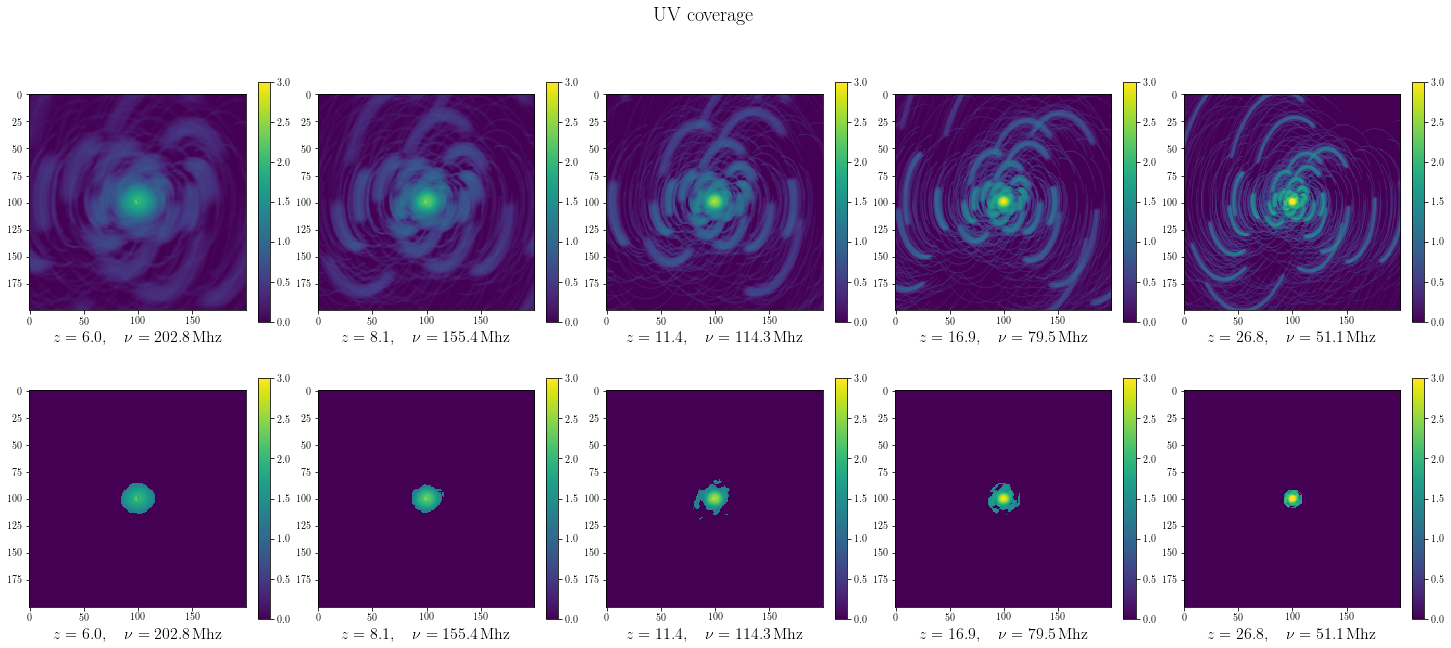

In [6]:
plt.figure(figsize=(25, 5 * 2))
for i in range(5):
    plt.subplot(2, 5, 1 + i)
    a = np.fft.fftshift(uv[..., i * 500])
    plt.imshow(np.log10(a+1), vmin = 0, vmax = 3)
    plt.xlabel(f"$z = {t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0):.1f}, \\quad \\nu = {t2c.cosmology.z_to_nu(t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0)):.1f} \\, \\mathrm{{Mhz}}$", fontsize=16)
    plt.colorbar(fraction=0.05, pad=0.05)
for i in range(5):
    plt.subplot(2, 5, 6 + i)
    a = np.fft.fftshift(uv_final[..., i * 500])
    plt.imshow(np.log10(a+1), vmin = 0, vmax = 3)
    plt.xlabel(f"$z = {t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0):.1f}, \\quad \\nu = {t2c.cosmology.z_to_nu(t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0)):.1f} \\, \\mathrm{{Mhz}}$", fontsize=16)
    plt.colorbar(fraction=0.05, pad=0.05)
plt.suptitle("UV coverage", fontsize=20);

In [7]:
my_uv = []
for i in range(5):
    my_uv.append(np.load(inputs.uv_filepath.rstrip(".npy") + f"_{i*500}.npy"))

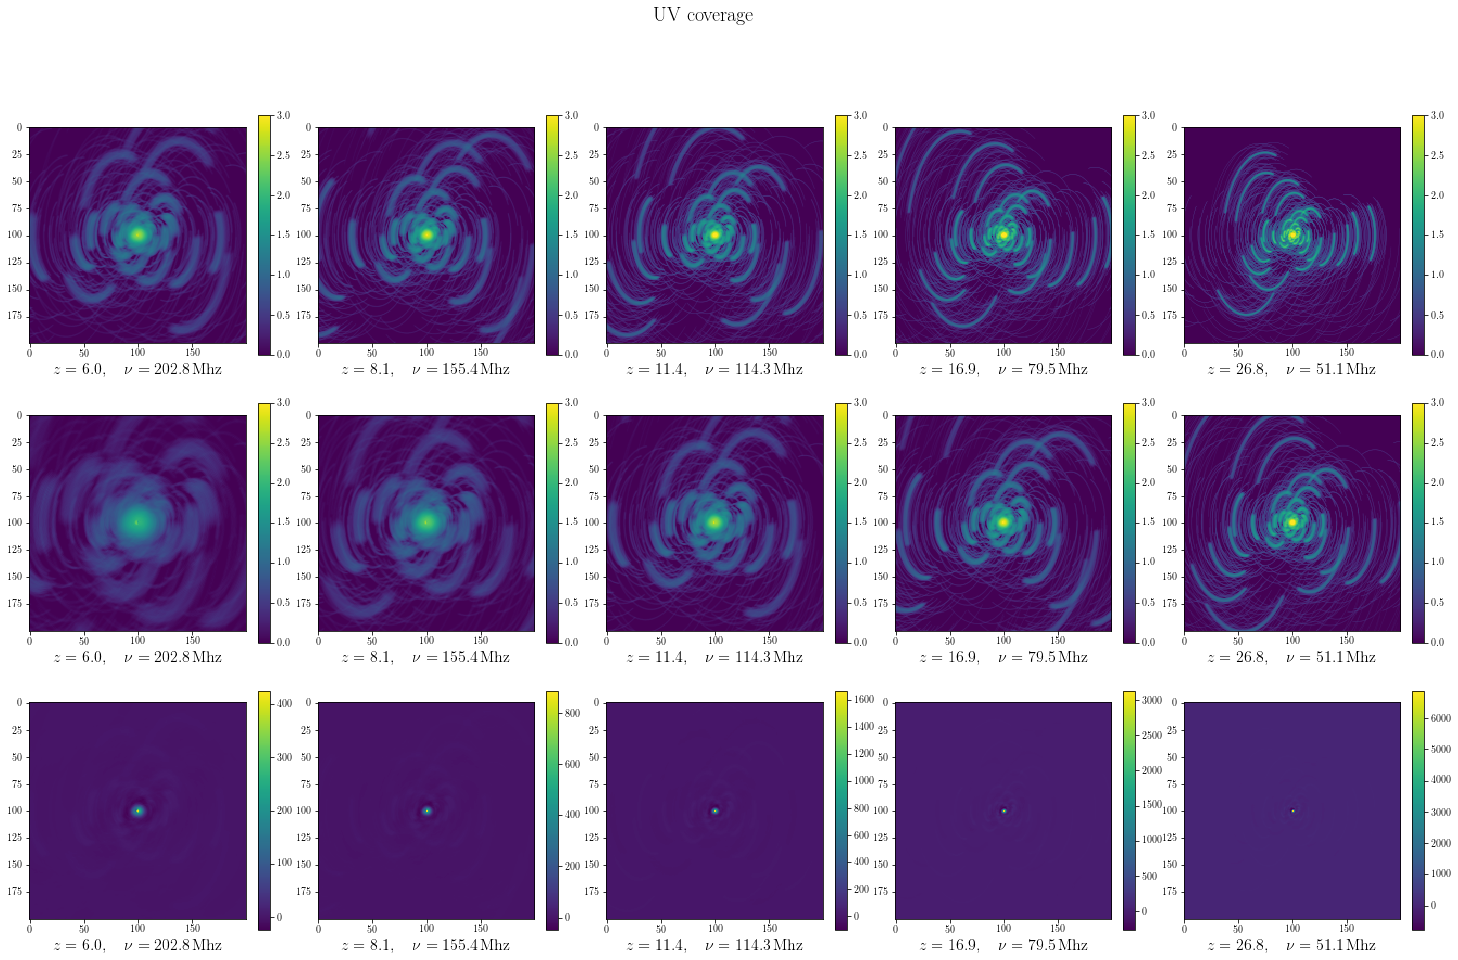

In [12]:
plt.figure(figsize=(25, 5 * 3))
for i in range(5):
    plt.subplot(3, 5, 1 + i)
    a = np.fft.fftshift(uv[..., i * 500])
    plt.imshow(np.log10(a+1), vmin = 0, vmax = 3)
    plt.xlabel(f"$z = {t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0):.1f}, \\quad \\nu = {t2c.cosmology.z_to_nu(t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0)):.1f} \\, \\mathrm{{Mhz}}$", fontsize=16)
    plt.colorbar(fraction=0.05, pad=0.05)
for i in range(5):
    plt.subplot(3, 5, 6 + i)
    a = my_uv[i]
    plt.imshow(np.log10(a+1), vmin = 0, vmax = 3)
    plt.xlabel(f"$z = {t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0):.1f}, \\quad \\nu = {t2c.cosmology.z_to_nu(t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0)):.1f} \\, \\mathrm{{Mhz}}$", fontsize=16)
    plt.colorbar(fraction=0.05, pad=0.05)
for i in range(5):
    plt.subplot(3, 5, 11 + i)
    a = np.fft.fftshift(uv[..., i * 500]) - my_uv[i]
    plt.imshow(a)
    plt.xlabel(f"$z = {t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0):.1f}, \\quad \\nu = {t2c.cosmology.z_to_nu(t2c.cosmology.cdist_to_z(i * 500 * 1.5 + d0)):.1f} \\, \\mathrm{{Mhz}}$", fontsize=16)
    plt.colorbar(fraction=0.05, pad=0.05)
plt.suptitle("UV coverage", fontsize=20)
plt.savefig("uv_covs.pdf");

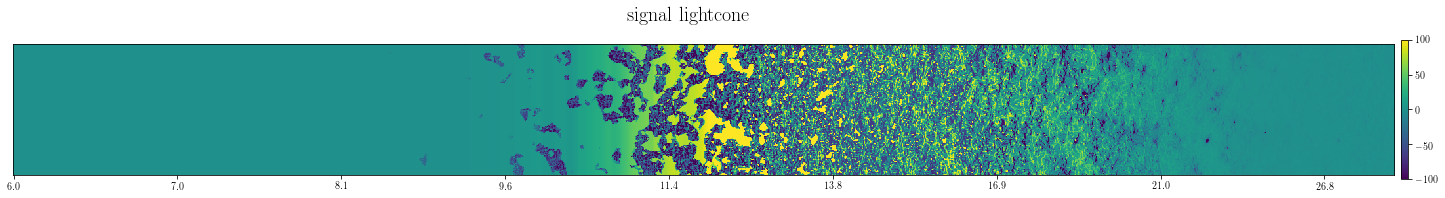

In [7]:
fig, ax =plt.subplots(1, 1, figsize=(25, 3))
im = ax.imshow(Box[0], vmin = -1e2, vmax = 1e2)
ax.set_xticks(np.array(range(9)) * 250)
ax.set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
ax.set_yticks([])
plt.colorbar(im, ax = ax, fraction=0.005, pad=0.005)
plt.suptitle("signal lightcone", fontsize=20);

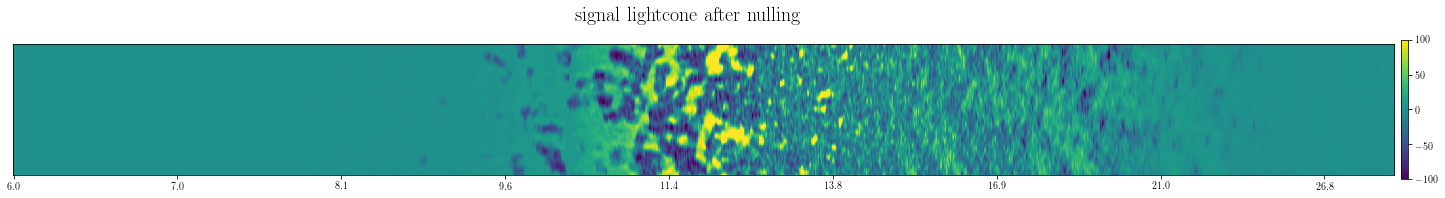

In [8]:
fig, ax =plt.subplots(1, 1, figsize=(25, 3))
x = np.fft.fft2(Box, axes = (0, 1))
x *= (uv_final != 0)
im = ax.imshow(np.real(np.fft.ifft2(x, axes = (0, 1))[0]), vmin = -1e2, vmax = 1e2)
ax.set_xticks(np.array(range(9)) * 250)
ax.set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
ax.set_yticks([])
plt.colorbar(im, ax = ax, fraction=0.005, pad=0.005)
plt.suptitle("signal lightcone after nulling", fontsize=20);

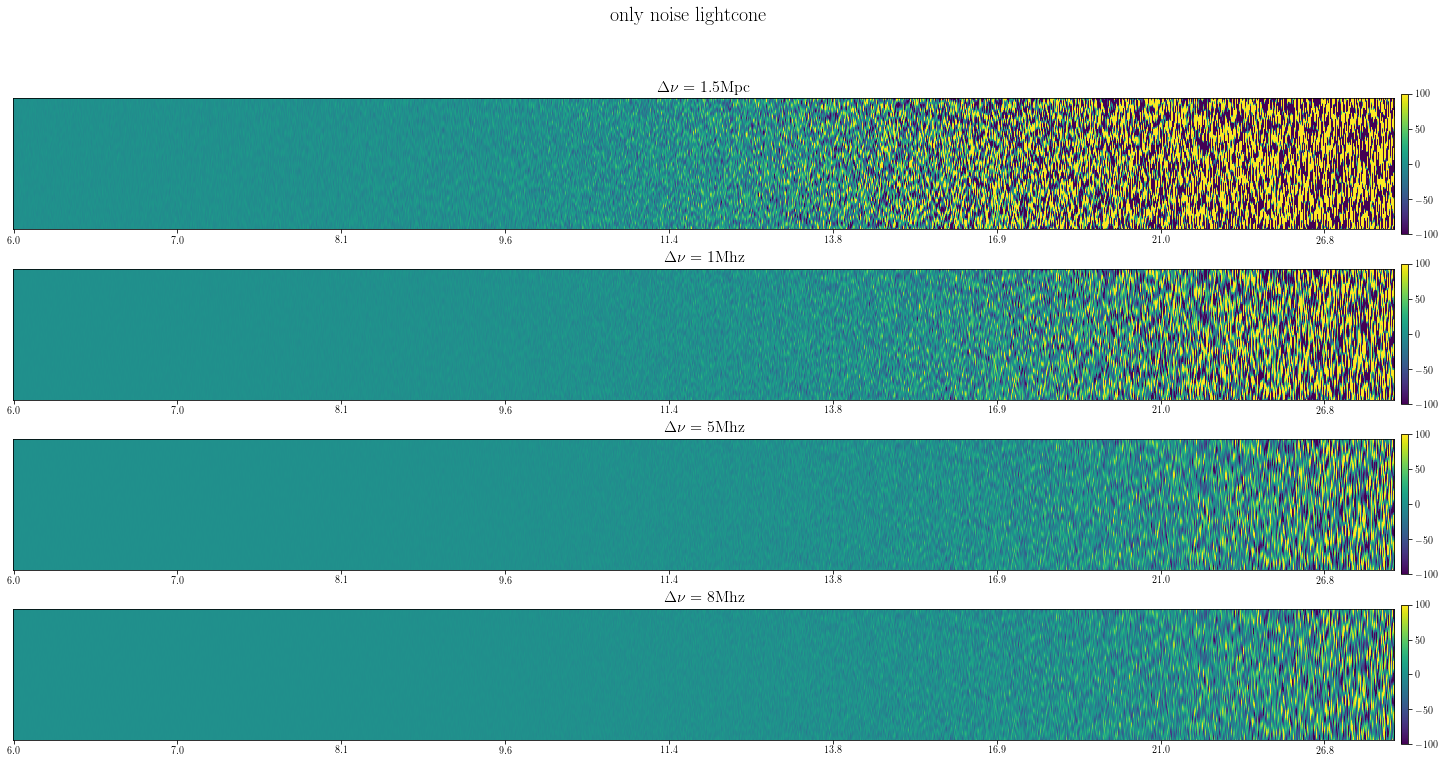

In [9]:
fig, ax =plt.subplots(4, 1, figsize=(25, 3*4))
d_nu = [0, 1, 5, 8]
d_nu_title = [f"$\\Delta\\nu = {i} \\mathrm{{Mhz}}$" if i != 0 else "$\\Delta\\nu = 1.5 \\mathrm{{Mpc}}$" for i in d_nu]
for i in range(4):
    im = ax[i].imshow(np.real(np.fft.ifft2(noise(Box, d_nu[i], uv_final), axes=(0, 1)))[0], vmin = -1e2, vmax = 1e2)
    ax[i].set_xticks(np.array(range(9)) * 250)
    ax[i].set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
    ax[i].set_yticks([])
    plt.colorbar(im, ax = ax[i], fraction=0.005, pad=0.005)
    ax[i].set_title(d_nu_title[i], fontsize=16)
plt.suptitle(f"only noise lightcone", fontsize=20);

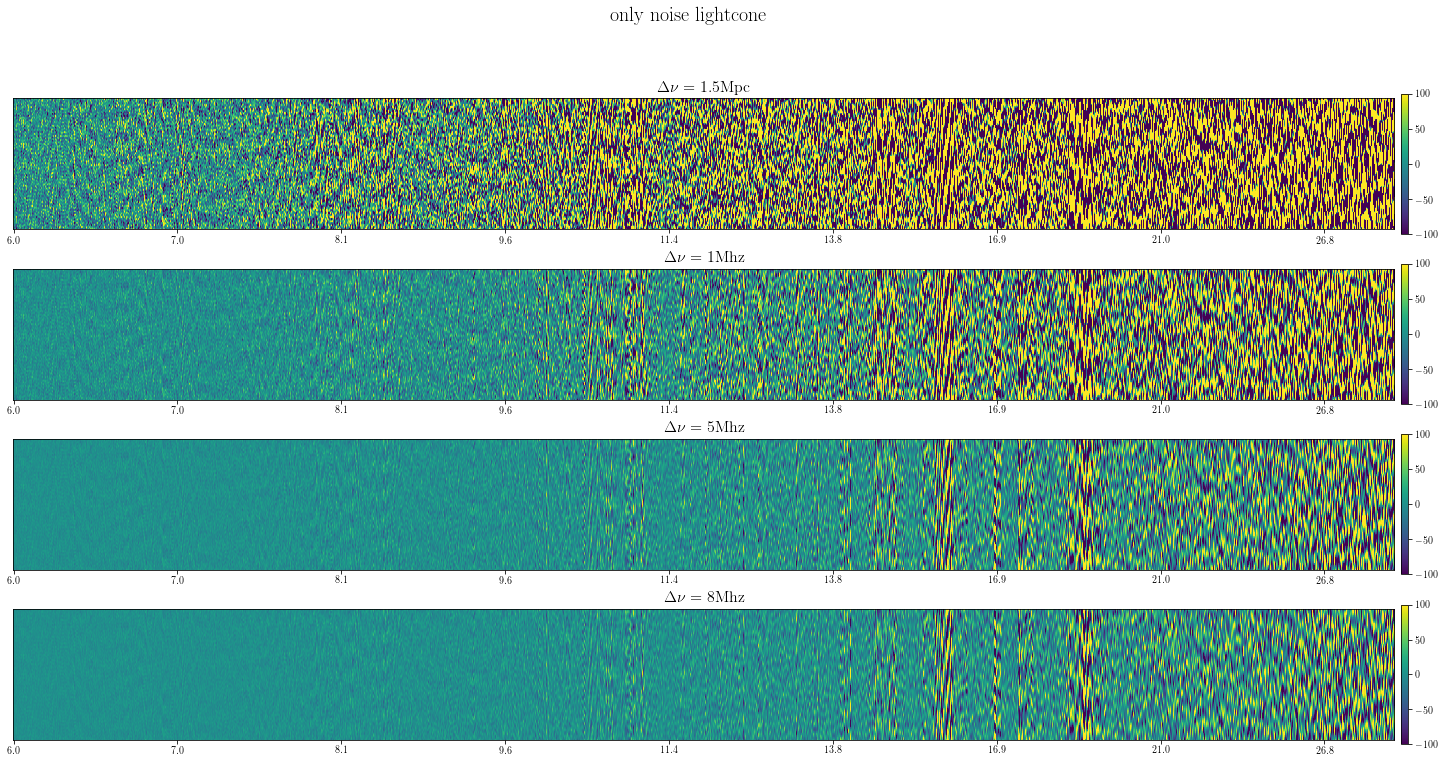

In [8]:
uv_max = max_baseline_cut(uv, u_max)
fig, ax =plt.subplots(4, 1, figsize=(25, 3*4))
d_nu = [0, 1, 5, 8]
d_nu_title = [f"$\\Delta\\nu = {i} \\mathrm{{Mhz}}$" if i != 0 else "$\\Delta\\nu = 1.5 \\mathrm{{Mpc}}$" for i in d_nu]
for i in range(4):
    im = ax[i].imshow(np.real(np.fft.ifft2(noise(Box, d_nu[i], uv_max), axes=(0, 1)))[0], vmin = -1e2, vmax = 1e2)
    ax[i].set_xticks(np.array(range(9)) * 250)
    ax[i].set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
    ax[i].set_yticks([])
    plt.colorbar(im, ax = ax[i], fraction=0.005, pad=0.005)
    ax[i].set_title(d_nu_title[i], fontsize=16)
plt.suptitle(f"only noise lightcone", fontsize=20);

Max amplitude is order of magnitude larger for $\Delta \nu = 1.5 \mathrm{Mpc}$. Seed is fixed for clarity, haven't done rebinning of frequency channels here.

In [5]:
x = noise_n_signal(Box, 0, uv_final)

fig, ax =plt.subplots(2, 1, figsize=(25, 3 * 2))
im = ax[0].imshow(x[0], vmin = -1e2, vmax = 1e2)
ax[0].set_xticks(np.array(range(9)) * 250)
ax[0].set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
ax[0].set_yticks([])
plt.colorbar(im, ax = ax[0], fraction=0.005, pad=0.005)
ax[0].set_title("$\\Delta\\nu = 1.5 \\mathrm{{Mpc}}$", fontsize=16)

im = ax[1].imshow(Filters.BoxCar3D(x)[0], vmin = -1e2, vmax = 1e2)
ax[1].set_xticks(np.array(range(9)) * 250/4)
ax[1].set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
ax[1].set_yticks([])
plt.colorbar(im, ax = ax[1], fraction=0.005, pad=0.005)
ax[1].set_title("$\\Delta\\nu = 1.5 \\mathrm{{Mpc}},$ convolved with BoxCar(4, 4, 4)", fontsize=16)
plt.suptitle("signal + noise lightcone", fontsize=20);

NameError: name 'uv_final' is not defined

Last step is neccesary to reduce dimensionality of the data and to match it with existing models

### smoothing with tools21cm

/media/yqin/81614149-2ed8-4c76-82e1-c46763d086fa/pregi/anaconda3/envs/21cm/lib/python3.8/site-packages/tools21cm/helper_functions.py:555: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, np.complex) or
/media/yqin/81614149-2ed8-4c76-82e1-c46763d086fa/pregi/anaconda3/envs/21cm/lib/python3.8/site-packages/tools21cm/helper_functions.py:556: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, np.complex))


(50, 50, 526)
221.78419065475464


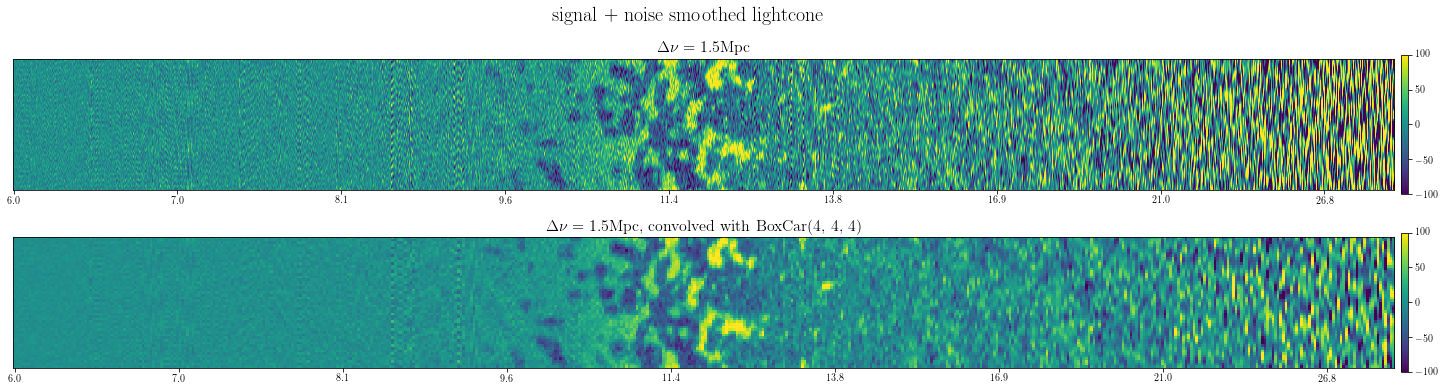

In [6]:
t = time.time()
x = noise_n_signal(Box, 0, uv)
x = smooth(x)

fig, ax =plt.subplots(2, 1, figsize=(25, 3 * 2))
im = ax[0].imshow(x[0], vmin = -1e2, vmax = 1e2)
ax[0].set_xticks(np.array(range(9)) * 250)
ax[0].set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
ax[0].set_yticks([])
plt.colorbar(im, ax = ax[0], fraction=0.005, pad=0.005)
ax[0].set_title("$\\Delta\\nu = 1.5 \\mathrm{{Mpc}}$", fontsize=16)
x = Filters.BoxCar3D(x)
print(x.shape)
im = ax[1].imshow(x[0], vmin = -1e2, vmax = 1e2)
ax[1].set_xticks(np.array(range(9)) * 250/4)
ax[1].set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
ax[1].set_yticks([])
plt.colorbar(im, ax = ax[1], fraction=0.005, pad=0.005)
ax[1].set_title("$\\Delta\\nu = 1.5 \\mathrm{{Mpc}},$ convolved with BoxCar(4, 4, 4)", fontsize=16)
plt.suptitle("signal + noise smoothed lightcone", fontsize=20)
print(time.time() - t)

(50, 50, 526)
79.22511577606201


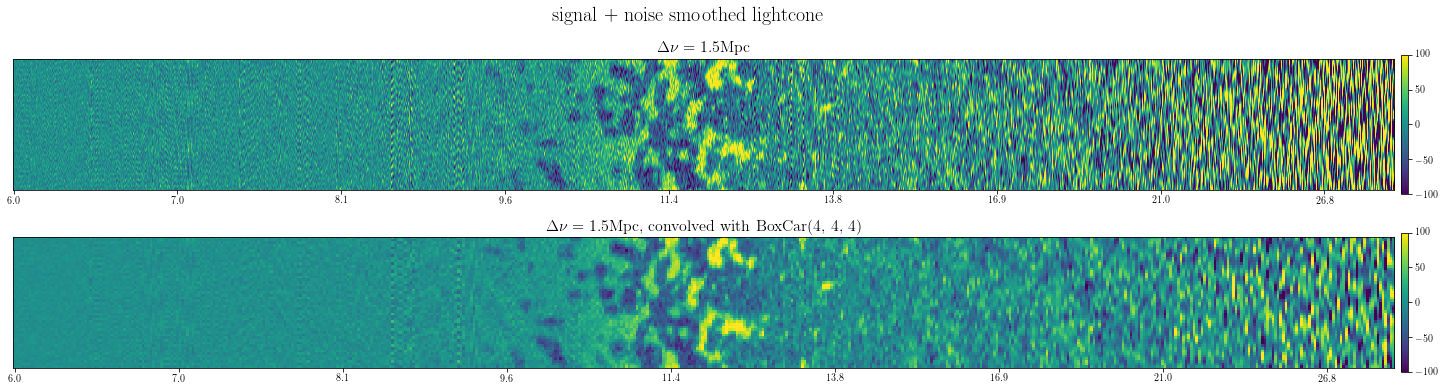

In [7]:
t = time.time()
y = noise_n_signal(Box, 0, uv)
y = smooth(y)

fig, ax =plt.subplots(2, 1, figsize=(25, 3 * 2))
im = ax[0].imshow(y[0], vmin = -1e2, vmax = 1e2)
ax[0].set_xticks(np.array(range(9)) * 250)
ax[0].set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
ax[0].set_yticks([])
plt.colorbar(im, ax = ax[0], fraction=0.005, pad=0.005)
ax[0].set_title("$\\Delta\\nu = 1.5 \\mathrm{{Mpc}}$", fontsize=16)
y = Filters.BoxCar3D_smart(y)
print(y.shape)

im = ax[1].imshow(y[0], vmin = -1e2, vmax = 1e2)
ax[1].set_xticks(np.array(range(9)) * 250/4)
ax[1].set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
ax[1].set_yticks([])
plt.colorbar(im, ax = ax[1], fraction=0.005, pad=0.005)
ax[1].set_title("$\\Delta\\nu = 1.5 \\mathrm{{Mpc}},$ convolved with BoxCar(4, 4, 4)", fontsize=16)
plt.suptitle("signal + noise smoothed lightcone", fontsize=20)
print(time.time() - t)

In [34]:
#testing the speed difference with np.einsum
z = noise_n_signal(Box, 0, uv)
z = smooth(z)

/media/yqin/81614149-2ed8-4c76-82e1-c46763d086fa/pregi/anaconda3/envs/21cm/lib/python3.8/site-packages/tools21cm/helper_functions.py:555: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, np.complex) or
/media/yqin/81614149-2ed8-4c76-82e1-c46763d086fa/pregi/anaconda3/envs/21cm/lib/python3.8/site-packages/tools21cm/helper_functions.py:556: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, np.complex))


0.6312975883483887
0.03743171691894531


In [45]:
s = Box.shape
t = time.time()
a = z[:s[0]//4*4, :s[1]//4*4, :s[2]//4*4].reshape((s[0]//4, 4, s[1]//4, 4, s[2]//4, 4)).mean((1, 3, 5))
print(time.time() - t)
t = time.time()
b = np.einsum('ijklmn->ikm', z[:s[0]//4*4, :s[1]//4*4, :s[2]//4*4].reshape((s[0]//4, 4, s[1]//4, 4, s[2]//4, 4))) / 4**3
print(time.time() - t)

0.590228796005249
0.2629091739654541


In [47]:
np.allclose(x, b)

True

Theallclosehing is done using tools21cm, the difference is due to the fact they are using gaussian with a bit larger equivalent $\sigma$ than in our case (factor of $1.4$), but the biggest difference is that gaussian kills "edge modes in uv" around max baseline completely.

The effect of the latter can be seen by correcting for the $\sigma$ and do the smoothing again:

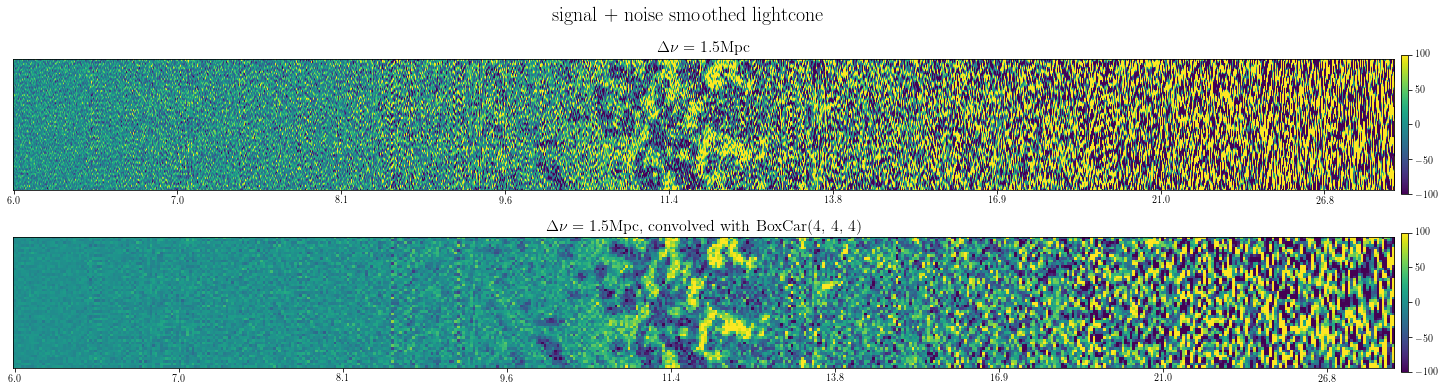

In [13]:
x = noise_n_signal(Box, 0, uv)
x = smooth(x, max_baseline = 2. * 1.41827)

fig, ax =plt.subplots(2, 1, figsize=(25, 3 * 2))
im = ax[0].imshow(x[0], vmin = -1e2, vmax = 1e2)
ax[0].set_xticks(np.array(range(9)) * 250)
ax[0].set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
ax[0].set_yticks([])
plt.colorbar(im, ax = ax[0], fraction=0.005, pad=0.005)
ax[0].set_title("$\\Delta\\nu = 1.5 \\mathrm{{Mpc}}$", fontsize=16)

im = ax[1].imshow(Filters.BoxCar3D(x)[0], vmin = -1e2, vmax = 1e2)
ax[1].set_xticks(np.array(range(9)) * 250/4)
ax[1].set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
ax[1].set_yticks([])
plt.colorbar(im, ax = ax[1], fraction=0.005, pad=0.005)
ax[1].set_title("$\\Delta\\nu = 1.5 \\mathrm{{Mpc}},$ convolved with BoxCar(4, 4, 4)", fontsize=16)
plt.suptitle("signal + noise smoothed lightcone", fontsize=20);

We got almost the same thing, but those large fluctuations at high redshift are lower in amplitude.

Those spurious signals clearly seen on lower redshifts might appear as here we don't have n>=15 cut. To check this we plot results only with uv cut:

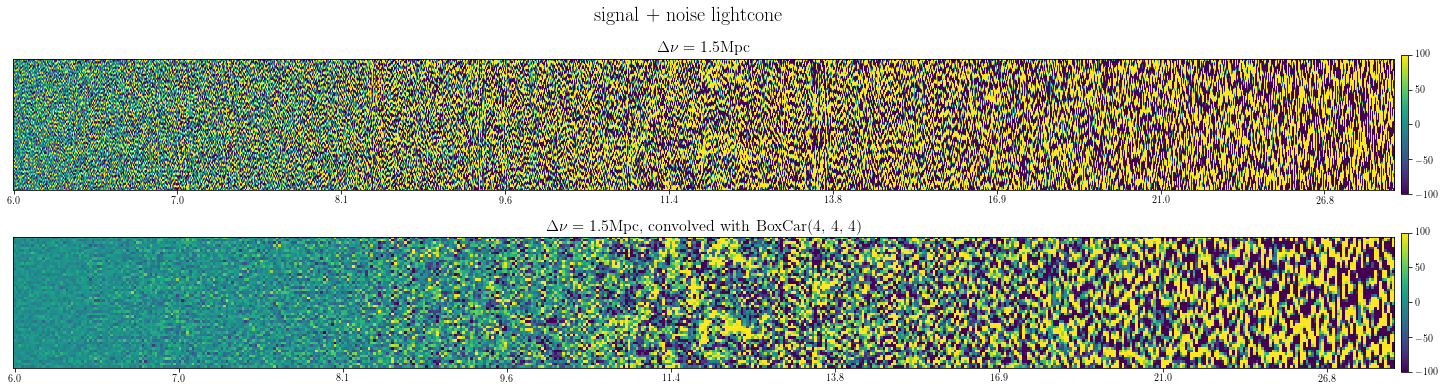

In [11]:
x = noise_n_signal(Box, 0, max_baseline_cut(uv, u_max))

fig, ax =plt.subplots(2, 1, figsize=(25, 3 * 2))
im = ax[0].imshow(x[0], vmin = -1e2, vmax = 1e2)
ax[0].set_xticks(np.array(range(9)) * 250)
ax[0].set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
ax[0].set_yticks([])
plt.colorbar(im, ax = ax[0], fraction=0.005, pad=0.005)
ax[0].set_title("$\\Delta\\nu = 1.5 \\mathrm{{Mpc}}$", fontsize=16)

im = ax[1].imshow(Filters.BoxCar3D(x)[0], vmin = -1e2, vmax = 1e2)
ax[1].set_xticks(np.array(range(9)) * 250/4)
ax[1].set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
ax[1].set_yticks([])
plt.colorbar(im, ax = ax[1], fraction=0.005, pad=0.005)
ax[1].set_title("$\\Delta\\nu = 1.5 \\mathrm{{Mpc}},$ convolved with BoxCar(4, 4, 4)", fontsize=16)
plt.suptitle("signal + noise lightcone", fontsize=20);

Indeed :)

In [27]:
plt.rc('text', usetex=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13


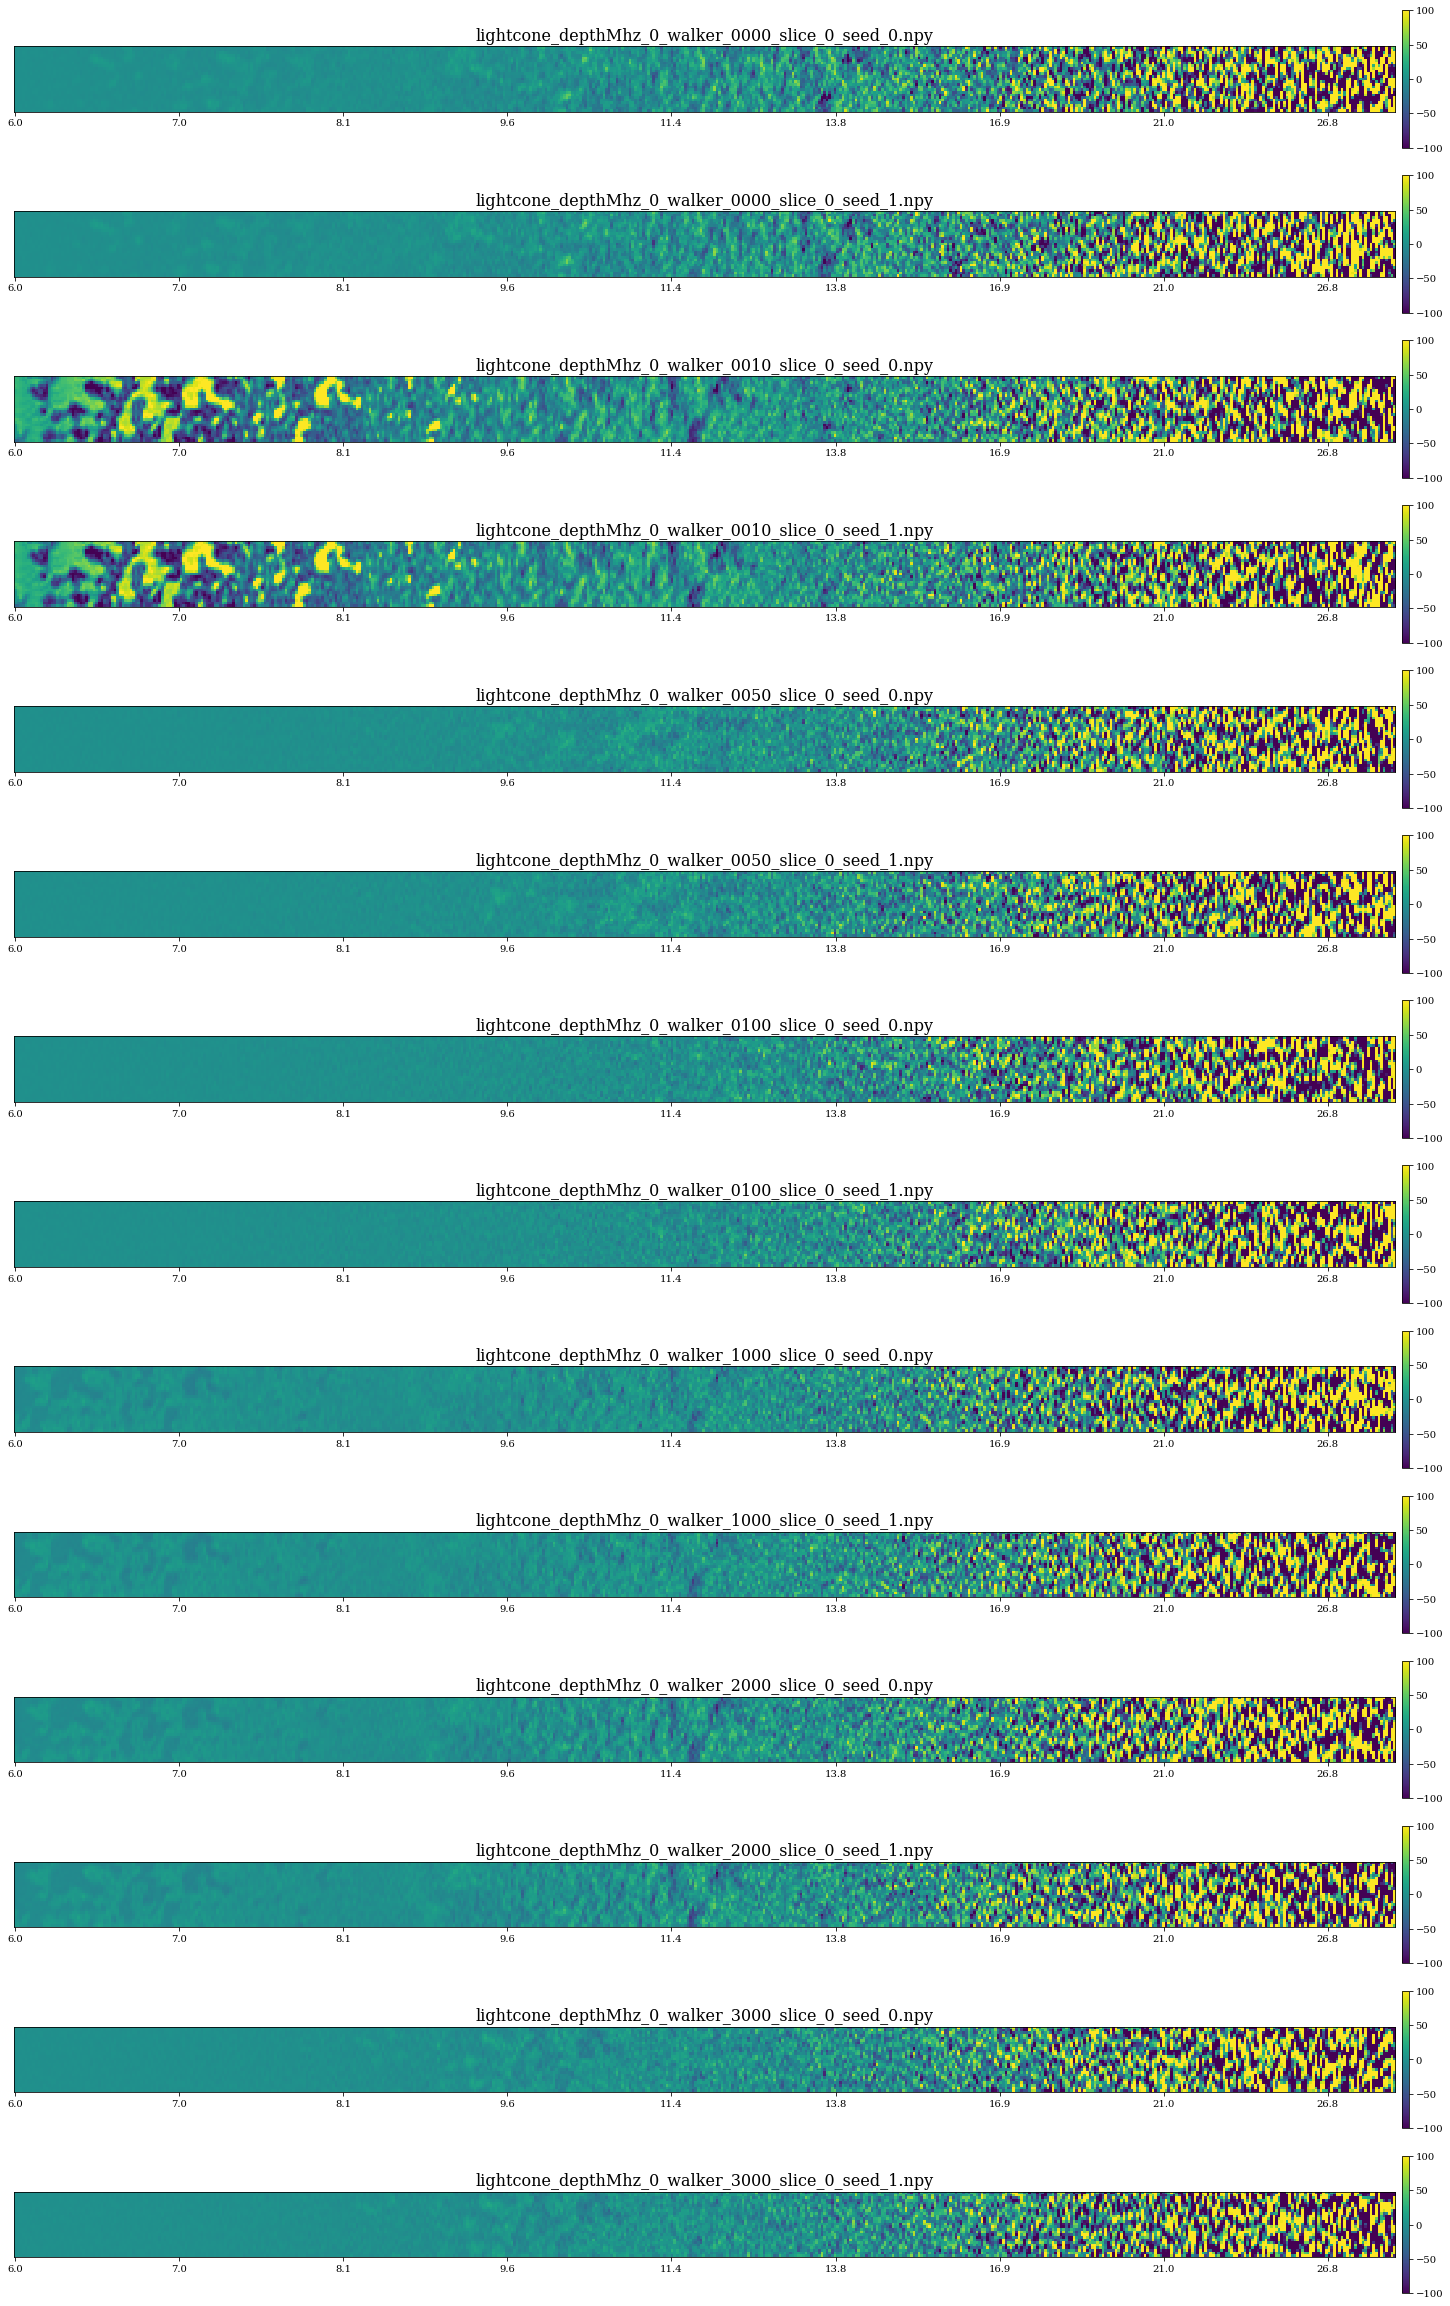

In [28]:
fig, ax =plt.subplots(14, 1, figsize=(25, 3*14))
# d_nu = [0, 1, 5, 8]
# d_nu_title = [f"$\\Delta\\nu = {i} \\mathrm{{Mhz}}$" if i != 0 else "$\\Delta\\nu = 1.5 \\mathrm{{Mpc}}$" for i in d_nu]
filepath = "../data/noise_final_test/"
with open(filepath + "for_thanatos.txt", "r") as f:
    for i in range(14):
        file = f.readline()[31:].rstrip("\n")
        x = np.load(filepath + file)
        im = ax[i].imshow(x[0], vmin = -1e2, vmax = 1e2)
        ax[i].set_xticks(np.array(range(9)) * 250/4)
        ax[i].set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
        ax[i].set_yticks([])
        plt.colorbar(im, ax = ax[i], fraction=0.005, pad=0.005)
        ax[i].set_title(f"{file}", fontsize=16)
        print(i)
#     plt.suptitle(f"on, fontsize=20);

0
1


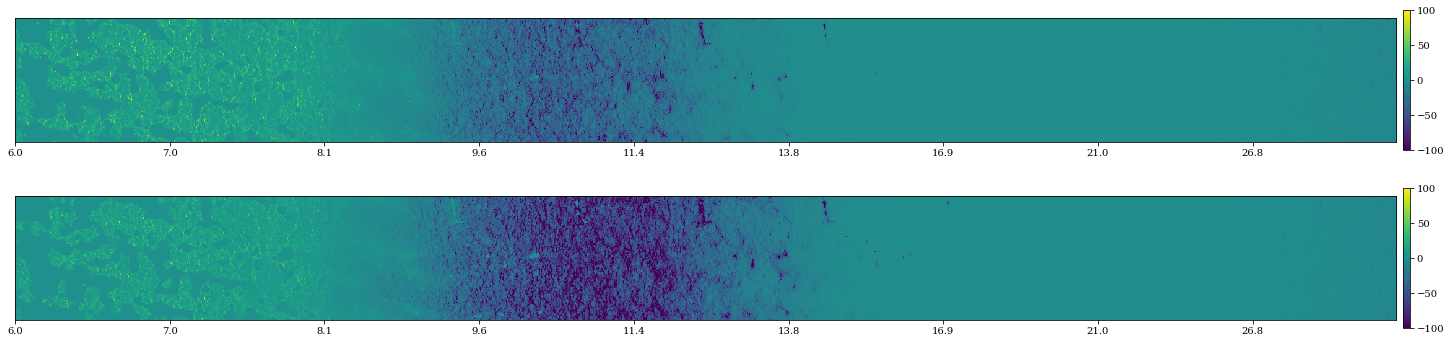

In [32]:
fig, ax =plt.subplots(2, 1, figsize=(25, 3*2))

for j in [1000, 2000]:
    Box = database.CombineBoxes(j)
    i = j//1000 - 1
    im = ax[i].imshow(Box[100], vmin = -1e2, vmax = 1e2)
    ax[i].set_xticks(np.array(range(9)) * 250)
    ax[i].set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
    ax[i].set_yticks([])
    plt.colorbar(im, ax = ax[i], fraction=0.005, pad=0.005)
#     ax[i].set_title(f"{file}", fontsize=16)
    print(i)